In [1843]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm

In [1844]:
from collections import namedtuple
from typing import OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8,8)
        self.fc2 = nn.Linear(8,8)
        self.fc3 = nn.Linear(8,8)
        self.fc4 = nn.Linear(8,8)
        self.fc5 = nn.Linear(8,8)
        self.fc6 = nn.Linear(8,8)
        self.NL = nn.Mish()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.NL(x)
        x = self.fc2(x)
        x = self.NL(x)
        x = self.fc3(x)
        x = self.NL(x)
        x = self.fc4(x)
        x = self.NL(x)
        x = self.fc5(x)
        x = self.NL(x)
        x = self.fc6(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8,8)
        self.fc2 = nn.Linear(8,8)
        self.fc3 = nn.Linear(8,8)
        self.fc4 = nn.Linear(8,8)
        self.fc5 = nn.Linear(8,8)
        self.fc6 = nn.Linear(8,4)
        self.fc7 = nn.Linear(4,2)
        self.fc8 = nn.Linear(2,1)
        self.NL = nn.Mish()
        self.sigmoid = nn.Sigmoid()
        self.twodim = None
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.NL(x)
        x = self.fc2(x)
        x = self.NL(x)
        x = self.fc3(x)
        x = self.NL(x)
        x = self.fc4(x)
        x = self.NL(x)
        x = self.fc5(x)
        x = self.NL(x)
        x = self.fc6(x)
        x = self.NL(x)
        x = self.fc7(x)
        self.twodim = x
        x = self.fc8(x)
        x = self.sigmoid(x)
        return x

In [1845]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()

Optimizer = namedtuple('Optimizer', ['G', 'D'])
optimizer = Optimizer(optim.AdamW(G.parameters(), lr=1e-4),
                      optim.AdamW(D.parameters(), lr=1e-4))
                      
def zero_grad():
    optimizer.G.zero_grad()
    optimizer.D.zero_grad()

def dataset(batchsize=1):
    l = torch.linspace(0, torch.pi, 8)
    while True:
        yield torch.empty(batchsize, 8).normal_(0, .05) + l.cos()*3

In [1846]:
import os
import shutil
try:
    os.remove('eightpoint.csv')
except:
    pass

try:
    shutil.rmtree('./models', ignore_errors=False, onerror=None)
except:
    pass

try:
    os.mkdir('./models')
except:
    pass

D.train()
G.train()

batchsize = 64
iteration = 4000
best_loss = torch.inf

for i, data in tqdm(enumerate(dataset(batchsize=batchsize))):
    if i == iteration: break

    # D train
    zero_grad()

    y_hat_real = D(data)
    loss_real = criterion(y_hat_real, torch.ones(batchsize, 1))
    
    z = torch.empty(batchsize, 8).normal_(0, .1)
    y_hat_fake = D(G(z))
    loss_fake = criterion(y_hat_fake, torch.zeros(batchsize, 1))

    loss_D = loss_real + loss_fake
    loss_D.backward()
    optimizer.D.step()

    # G train
    zero_grad()

    z = torch.empty(batchsize, 8).normal_(0, .1)
    y_hat_fake = D(G(z))
    loss_G = criterion(y_hat_fake, torch.ones(batchsize, 1))
    loss_G.backward()
    optimizer.G.step()

    with open('eightpoint.csv', 'a') as f:
        f.write(f'{i},{loss_D/batchsize},{loss_real/batchsize},{loss_fake/batchsize},{loss_G/batchsize}\n')

    if loss_G-loss_D/2 < best_loss:
        best_loss = loss_D - loss_G
        torch.save(D, f'./models/D_{i}.pt')
        torch.save(G, f'./models/G_{i}.pt')

4000it [00:30, 131.66it/s]


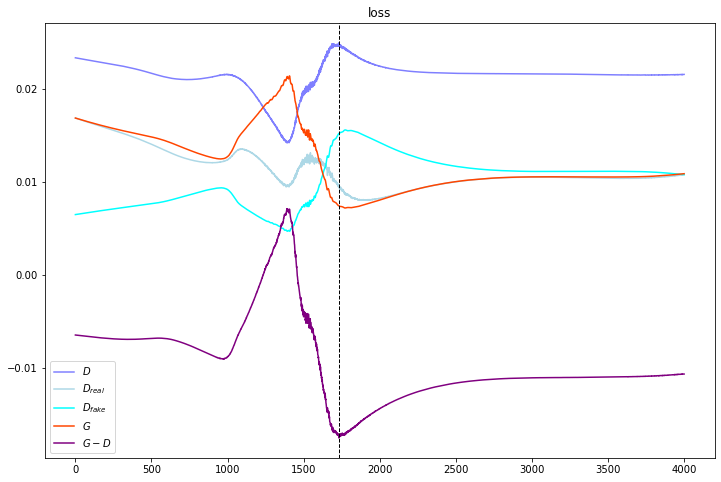

minidx = 1732


In [1847]:
import pandas as pd

df = pd.read_csv('eightpoint.csv', header=None)
df.columns = ['iter', 'D', 'D_real', 'D_fake', 'G']

plt.figure(figsize=(12,8))
plt.title('loss')
plt.plot(df['D'],      label=r'$D$', c='blue', alpha=.5)
plt.plot(df['D_real'], label=r'$D_{real}$', c='lightblue')
plt.plot(df['D_fake'], label=r'$D_{fake}$', c='cyan')
plt.plot(df['G'],      label=r'$G$', c='orangered')
plt.plot((df['G']-df['D']), label=r'$G-D$', c='purple')
plt.axvline((df['G']-df['D']).idxmin(), c='k', ls='--', lw=1)
plt.legend()
plt.show()

minidx = (df['G']-df['D']).idxmin()
print(f'{minidx = }')

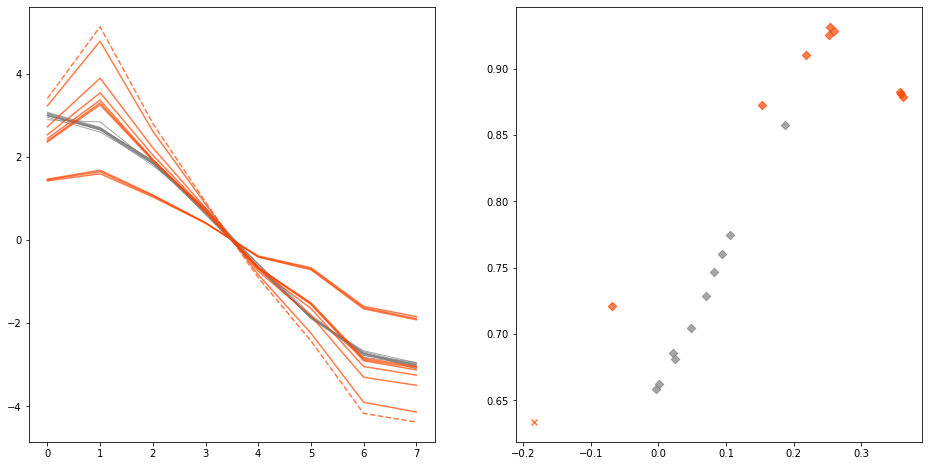

In [1848]:
G = torch.load(f'./models/G_{minidx}.pt')
D = torch.load(f'./models/D_{minidx}.pt')
G.eval()
D.eval()

n = 10
d = dataset(batchsize=n)

plt.figure(figsize=(16,8))
plt.subplot(121)
for rows in d:
    for row in rows:
        plt.plot(row, c='grey', alpha=.7, lw='1')
    break

z = torch.empty(n, 8).normal_(0, 5)
plt.subplot(121)
for row in G(z).detach():
    if D(row) > .5:
        plt.plot(row, c='orangered', alpha=.7)
    else:
        plt.plot(row, c='orangered', ls='--', alpha=.7)


plt.subplot(122)
for rows in d:
    for row in rows:
        # print(f'{D(row).item():>7.3f}', end=' ')
        if D(row) > .5:
            plt.scatter(*D.twodim.detach(), c='grey', alpha=.7, marker='D')
        else:
            plt.scatter(*D.twodim.detach(), c='grey', alpha=.7, marker='x')
    break
print()
for row in G(z).detach():
    # print(f'{D(row).item():>7.3f}', end=' ')
    if D(row) > .5:
        plt.scatter(*D.twodim.detach(), c='orangered', alpha=.7, marker='D')
    else:
        plt.scatter(*D.twodim.detach(), c='orangered', alpha=.7, marker='x')
print()
plt.show()